# Stock Price Prediction

* The main flow of code is referenced in this [blog](https://medium.com/@aniruddha.choudhury94/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68)

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time
import glob
#import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.INFO)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Data Download

* We colud download daliy stock price using `fix_yahoo_finance` library.
* Some stock ticker symbols [NASDAQ] [link](http://eoddata.com/symbols.aspx)
  * `AAPL`: Apple Inc.
  * `AMZM`: Amazon.com Inc.
  * `GOOG`: Alphabet Class C (Google)
  * `MSFT`: Microsoft Corp.

In [2]:
import fix_yahoo_finance as yf

dataset = yf.download(tickers='AAPL', start='2016-01-01', end='2018-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 downloaded


In [3]:
dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-12-31,101.500375,101.519342,99.423129,99.840477,40635300
2016-01-04,97.326927,99.944825,96.748333,99.925850,67649400
2016-01-05,100.305248,100.400098,97.137219,97.421768,55791000
2016-01-06,95.382453,97.099266,94.727984,95.515244,68457400
2016-01-07,93.599272,94.974613,91.465118,91.484085,81094400


### Data Preprocessing

1. Data discretization: Part of data reduction but with particular importance, especially for numerical data
2. Data transformation: Normalization.
3. Data cleaning: Fill in missing values.
4. Data integration: Integration of data files.

After the dataset is transformed into a clean dataset, the dataset is divided into training and testing sets so as to evaluate. Creating a data structure with 60 timesteps and 1 output

In [4]:
#Data cleaning
dataset.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2015-12-31 to 2017-12-29
Data columns (total 5 columns):
Open      504 non-null float64
High      504 non-null float64
Low       504 non-null float64
Close     504 non-null float64
Volume    504 non-null int64
dtypes: float64(4), int64(1)
memory usage: 23.6 KB


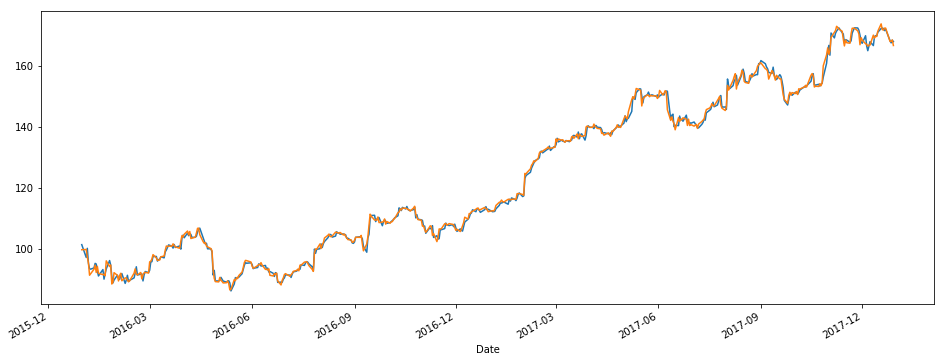

In [6]:
dataset['Open'].plot(figsize=(16, 6))
dataset.Close.plot(figsize=(16, 6))
plt.show()

In [7]:
# convert column to float type when column type is an object
#dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)

In [8]:
# 7 day rolling mean
dataset.rolling(7).mean().head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN
2016-01-04,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN
2016-01-11,96.494936,97.414993,94.801163,95.658888,6.202356e+07
2016-01-12,95.619593,96.555910,93.990860,94.940726,6.324054e+07
2016-01-13,95.309294,95.989512,93.354002,93.862132,6.249629e+07


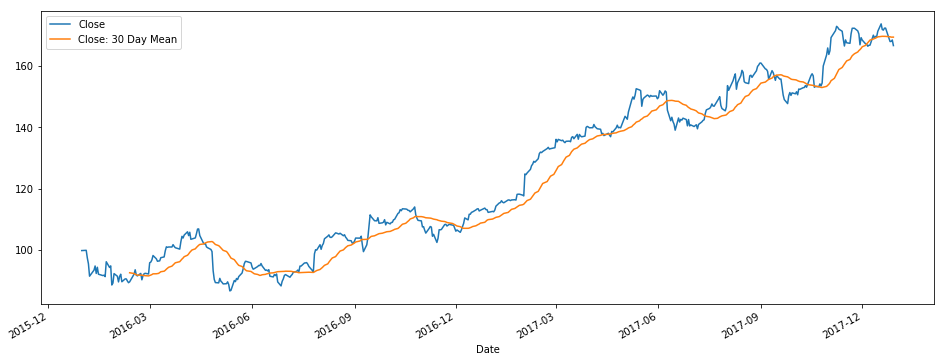

In [9]:
dataset['Close: 30 Day Mean'] = dataset.Close.rolling(window=30).mean()
dataset[['Close', 'Close: 30 Day Mean']].plot(figsize=(16, 6))
plt.show()

### Make a training dataset

In [10]:
train_data = dataset['Open']
train_data = pd.DataFrame(train_data)

In [11]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)

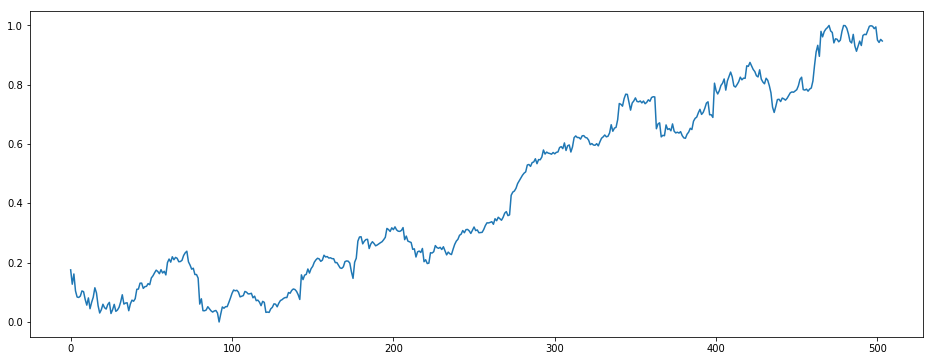

In [12]:
plt.figure(figsize=(16, 6))
plt.plot(train_data_scaled)
plt.show()

In [13]:
# Creating a data structure with 60 timesteps and 1 output
past_days = 60
X_train = []
y_train = []
for i in range(past_days, len(train_data_scaled)):
  X_train.append(train_data_scaled[i-past_days:i, 0])
  y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Cast
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [14]:
# We predict the price of next day given past 60 days prices
print(X_train.shape)
print(y_train.shape)

(444, 60, 1)
(444,)


## Build a model

In [15]:
model = tf.keras.Sequential()

In [16]:
# Adding the first LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(past_days, 1)))
model.add(layers.Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))

# Adding the output layer
model.add(layers.Dense(units=1))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [18]:
model(X_train[0:2])[0]

<tf.Tensor: id=14622, shape=(1,), dtype=float32, numpy=array([0.01435625], dtype=float32)>

In [19]:
# Compiling the RNN
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
14/14 [==============================] - 15s 1s/step - loss: 0.0619
Epoch 2/50
14/14 [==============================] - 19s 1s/step - loss: 0.0163
Epoch 3/50
14/14 [==============================] - 15s 1s/step - loss: 0.0132
Epoch 4/50
14/14 [==============================] - 15s 1s/step - loss: 0.0085
Epoch 5/50
14/14 [==============================] - 13s 961ms/step - loss: 0.0075
Epoch 6/50
14/14 [==============================] - 17s 1s/step - loss: 0.0060
Epoch 7/50
14/14 [==============================] - 15s 1s/step - loss: 0.0056
Epoch 8/50
14/14 [==============================] - 14s 1s/step - loss: 0.0056
Epoch 9/50
14/14 [==============================] - 14s 1s/step - loss: 0.0069
Epoch 10/50
14/14 [==============================] - 14s 966ms/step - loss: 0.0051
Epoch 11/50
14/14 [==============================] - 14s 1s/step - loss: 0.0046
Epoch 12/50
14/14 [==============================] - 14s 992ms/step - loss: 0.0052
Epoch 13/50
14/14 [=====================

In [21]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = yf.download(tickers='AAPL', start='2018-01-01', end='2018-02-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 downloaded


In [22]:
dataset_test.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,167.643137,169.751483,166.756441,169.712067,25555900
2018-01-03,169.978076,171.968201,169.416514,169.682510,29517900
2018-01-04,169.987945,170.904197,169.534757,170.470703,22434600
2018-01-05,170.874636,172.776082,170.490406,172.411560,23660000
2018-01-08,171.771179,173.012537,171.357378,171.771179,20567800


In [23]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2018-01-02 to 2018-01-31
Data columns (total 5 columns):
Open      21 non-null float64
High      21 non-null float64
Low       21 non-null float64
Close     21 non-null float64
Volume    21 non-null int64
dtypes: float64(4), int64(1)
memory usage: 1008.0 bytes


In [24]:
test_data = dataset_test['Open']
test_data = pd.DataFrame(test_data)

In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2018-01-02 to 2018-01-31
Data columns (total 1 columns):
Open    21 non-null float64
dtypes: float64(1)
memory usage: 336.0 bytes


In [26]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_data)

In [27]:
test_set_scaled = pd.DataFrame(test_set_scaled)
test_set_scaled.head()

,0
0,0.334537
1,0.505779
2,0.506503
3,0.571532
4,0.637283


In [28]:
# Getting the predicted stock price of 2018
dataset_total = pd.concat((dataset['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - past_days:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

prediction_days = dataset_test.shape[0]
for i in range(past_days, past_days + prediction_days):
  X_test.append(inputs[i-past_days:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Cast
X_test = X_test.astype(np.float32)

In [29]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

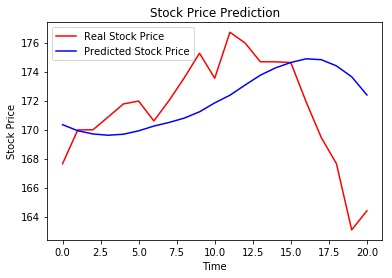

In [30]:
# Visualising the results
real_stock_price = dataset_test.Open.values
plt.plot(real_stock_price, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()